In [1]:
# Cell 1 - Imports et paramètres globaux
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import skew
import scipy.cluster.hierarchy as sch
from ydata_profiling import ProfileReport


/opt/anaconda3/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/anaconda3/lib/python3.9/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
# Réglages d'affichage
pd.set_option("display.max_columns", 200)
sns.set(style="whitegrid")

In [3]:
# Chargement des données traitées
train_df = pd.read_csv("../data/processed/train_merged.csv")
print("Shape train:", train_df.shape)


Shape train: (307511, 135)


In [4]:
#  Premier aperçu
train_df.head()


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,bureau_count,credit_active_unique,total_credit_sum,prev_app_count,avg_amt_app,total_amt_credit,pos_cash_count,avg_months_balance,credit_card_count,avg_credit_balance,installments_count,total_amt_payment,avg_days_entry_payment
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,2.0,865055.565,1.0,179055.00,179055.0,19.0,-10.000000,NaN,NaN,19.0,219625.695,-315.421053
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,1017400.500,3.0,435436.50,1452573.0,28.0,-43.785714,NaN,NaN,25.0,1618864.650,-

<Figure size 1200x600 with 0 Axes>

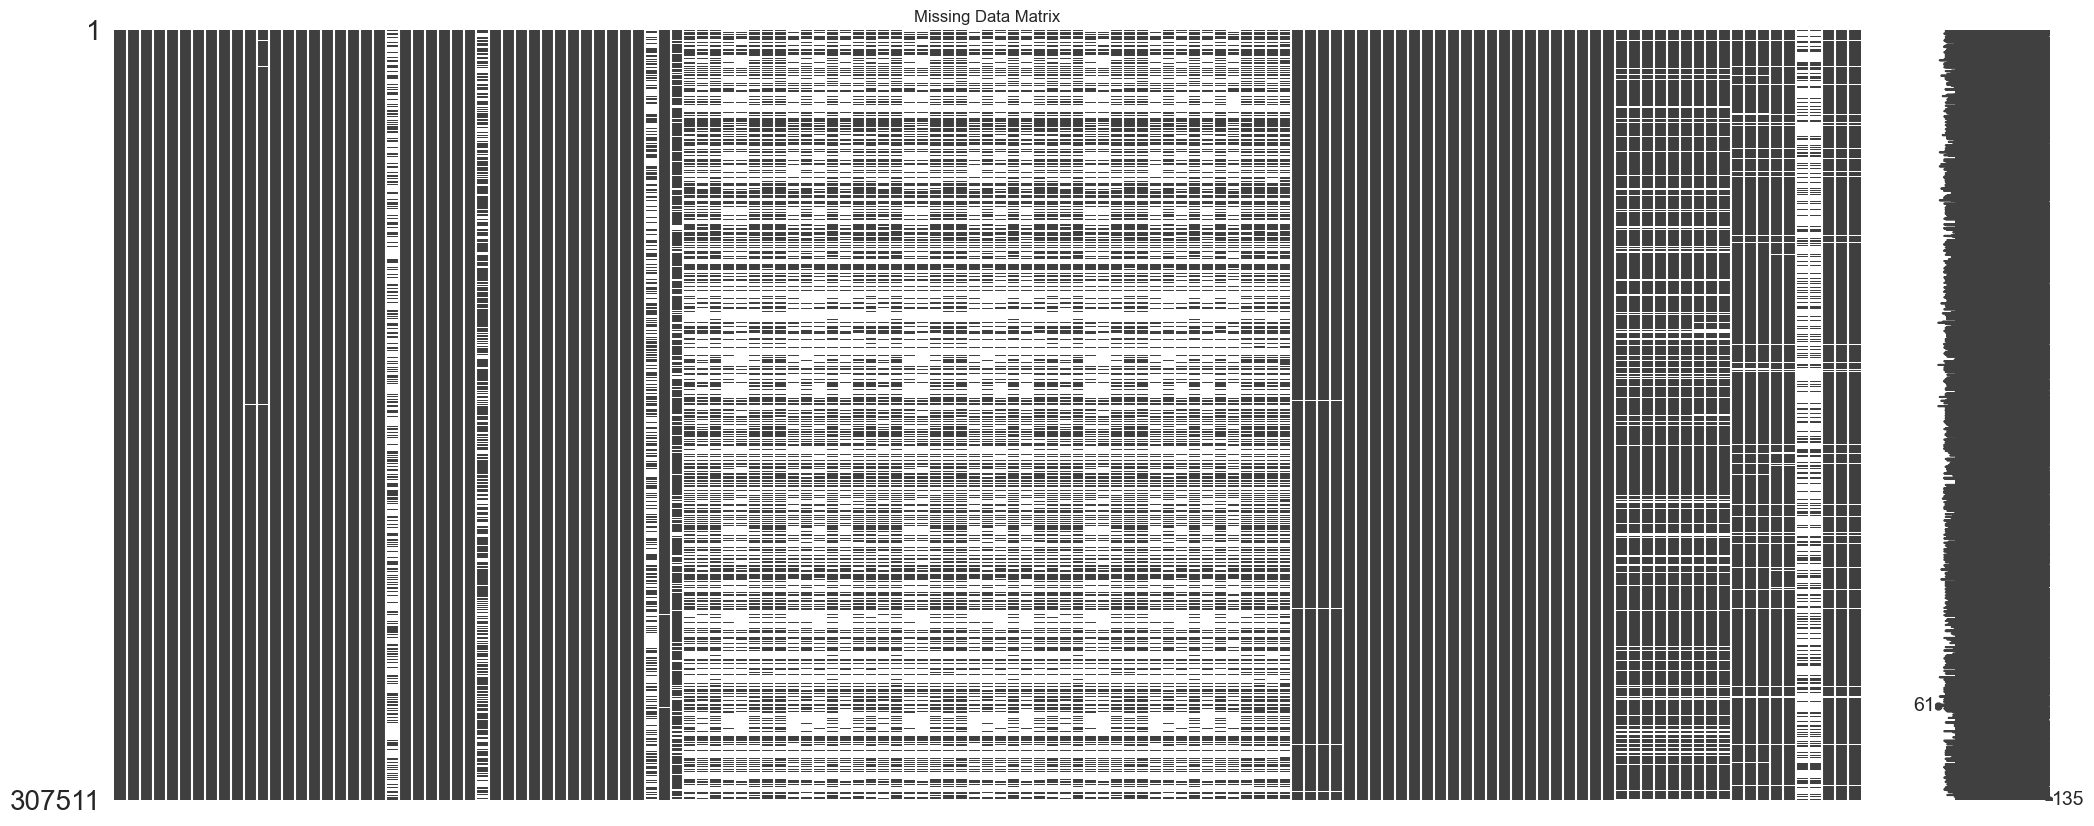

In [5]:
# Analyse des valeurs manquantes (missingno matrix)
plt.figure(figsize=(12, 6))
msno.matrix(train_df)
plt.title("Missing Data Matrix")
plt.show()


<Figure size 800x600 with 0 Axes>

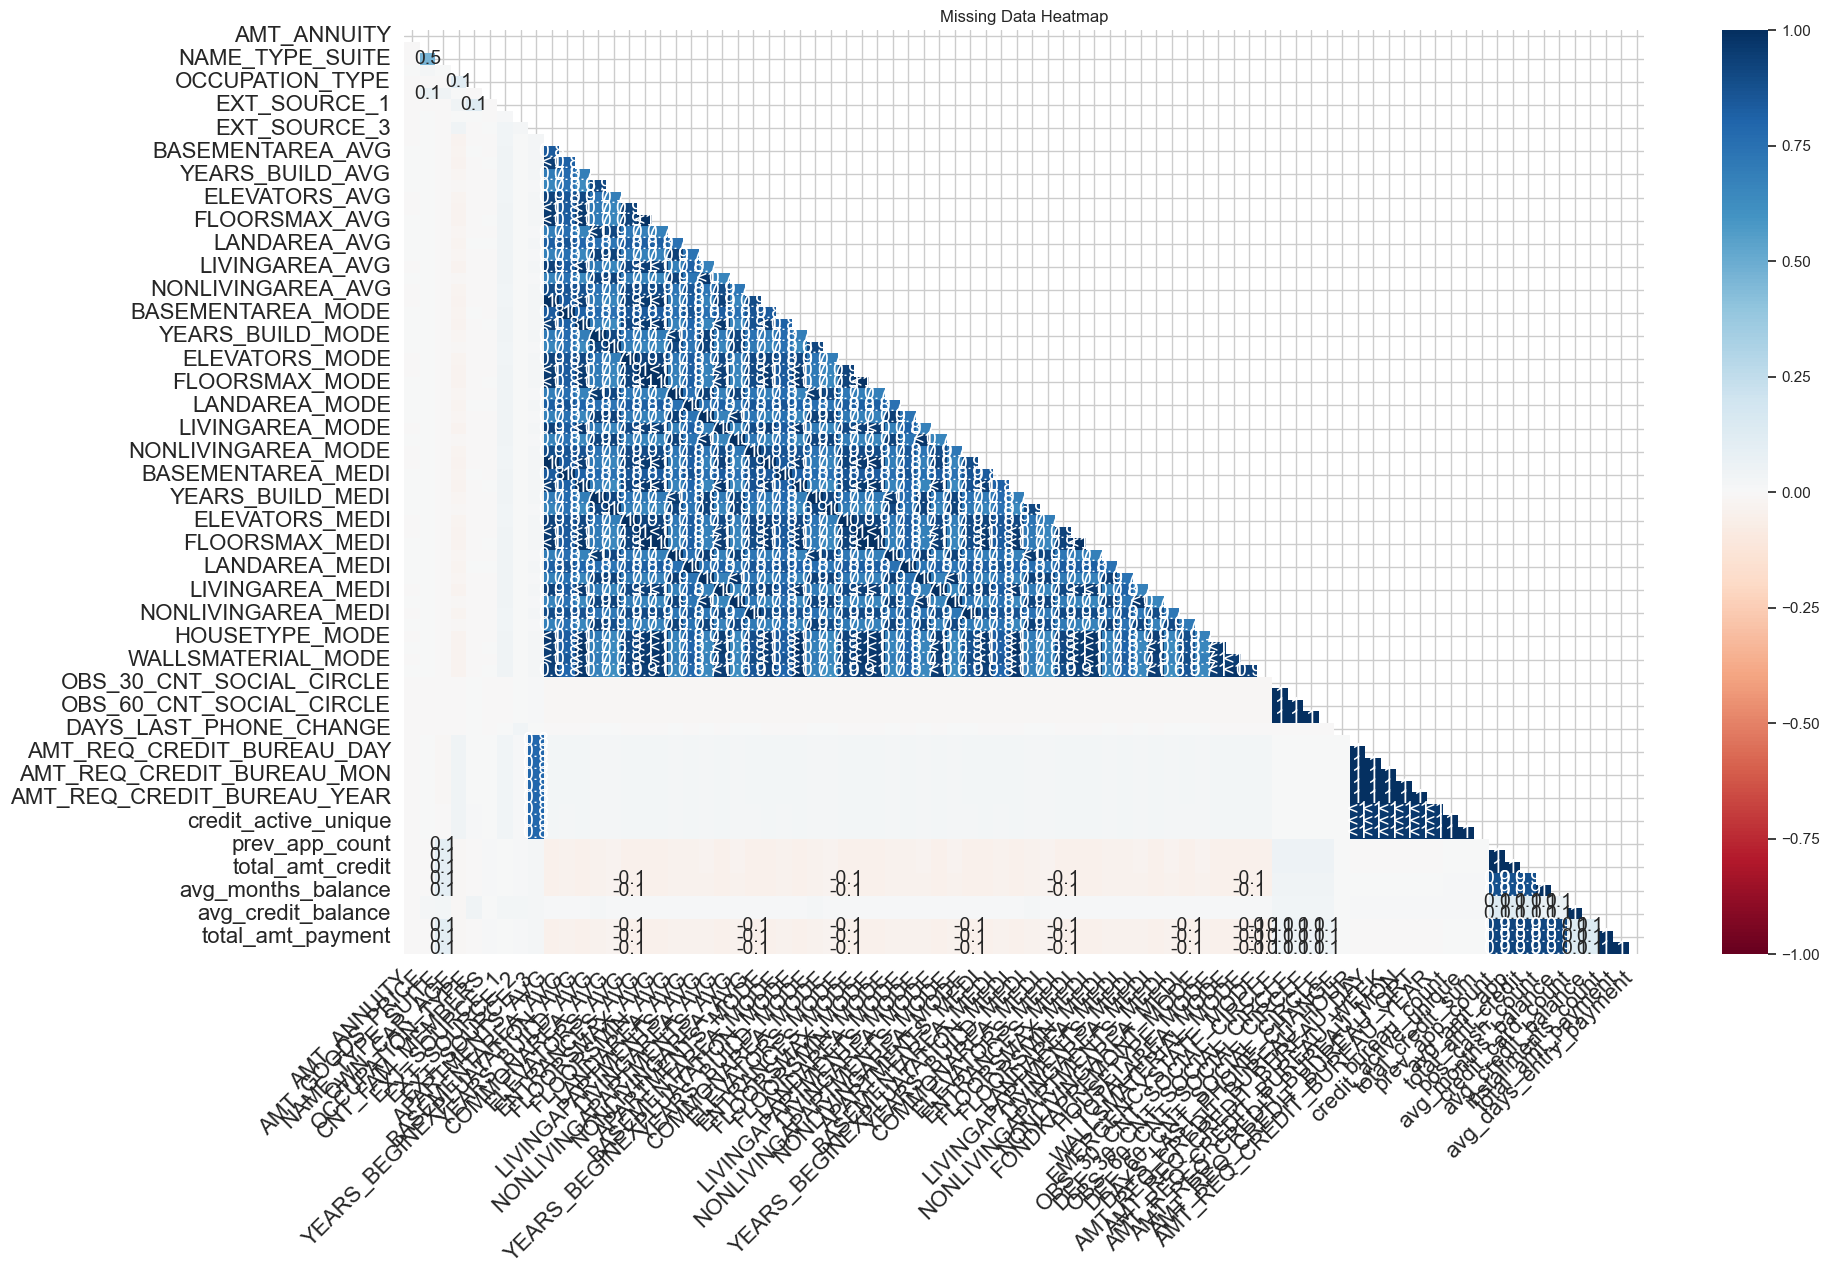

In [6]:
# Corrélations de missingness (missingno heatmap)
plt.figure(figsize=(8, 6))
msno.heatmap(train_df)
plt.title("Missing Data Heatmap")
plt.show()


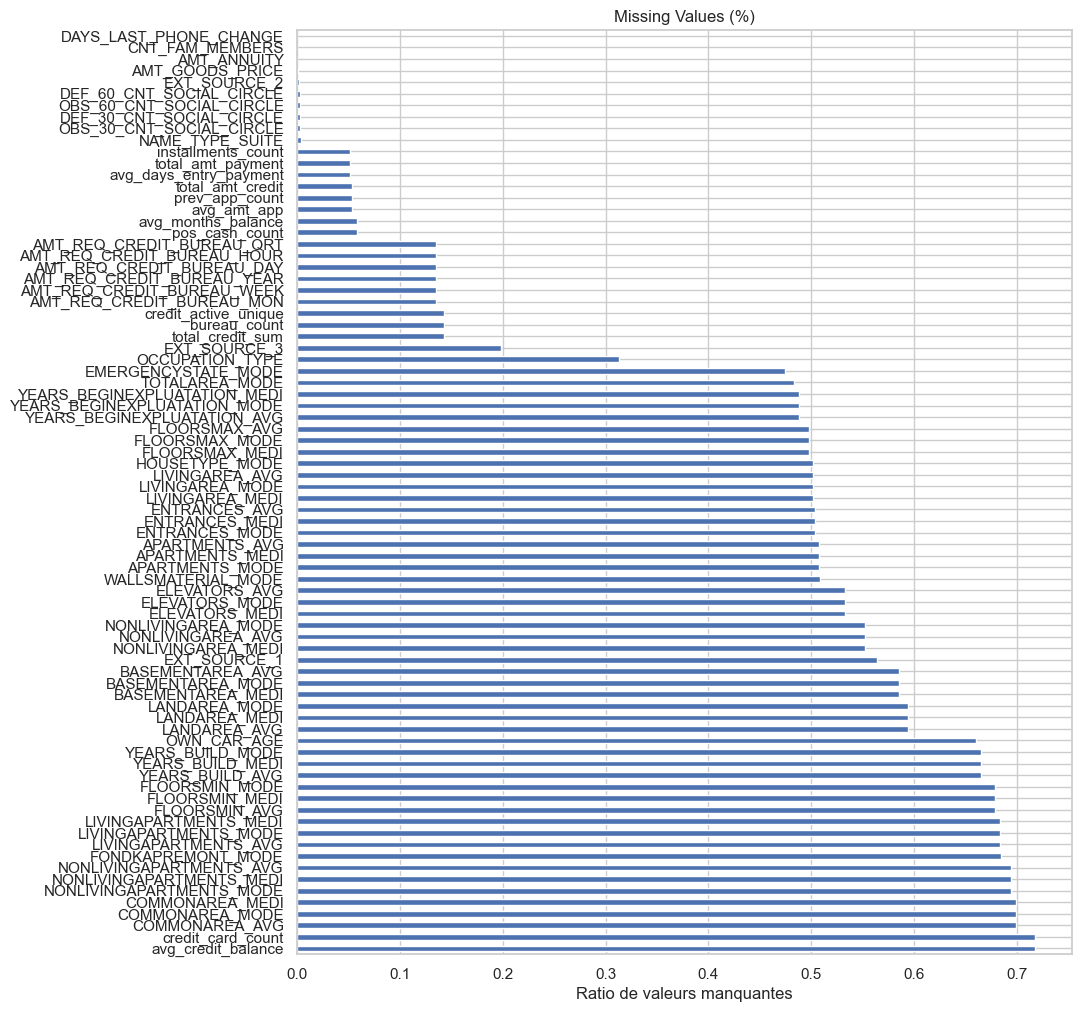

In [7]:
# Pourcentage de valeurs manquantes par variable
missing = train_df.isnull().mean().sort_values(ascending=False)
missing[missing > 0].plot(kind="barh", figsize=(10, 12))
plt.xlabel("Ratio de valeurs manquantes")
plt.title("Missing Values (%)")
plt.show()


In [8]:
# Statistiques descriptives globales
desc = train_df.describe().T
desc["skew"] = train_df.skew(numeric_only=True)
desc.sort_values("skew", ascending=False).head(10)


,count,mean,std,min,25%,50%,75%,max,skew
FLAG_DOCUMENT_12,307511.0,6.503832e-06,2.550257e-03,0.0,0.00,0.0,0.0,1.000000e+00,392.114779
AMT_INCOME_TOTAL,307511.0,1.687979e+05,2.371231e+05,25650.0,112500.00,147150.0,202500.0,1.170000e+08,391.559654
FLAG_DOCUMENT_10,307511.0,2.276341e-05,4.771055e-03,0.0,0.00,0.0,0.0,1.000000e+00,209.589054
FLAG_DOCUMENT_2,307511.0,4.227491e-05,6.501789e-03,0.0,0.00,0.0,0.0,1.000000e+00,153.791817
AMT_REQ_CREDIT_BUREAU_QRT,265992.0,2.654741e-01,7.940556e-01,0.0,0.00,0.0,0.0,2.610000e+02,134.365776
FLAG_DOCUMENT_4,307511.0,8.129790e-05,9.016183e-03,0.0,0.00,0.0,0.0,1.000000e+00,110.894364
total_credit_sum,263491.0,1.955807e+06,4.101728e+06,0.0,343377.27,961704.0,2297720.7,1.017958e+09,75.886871
FLAG_DOCUMENT_7,307511.0,1.918631e-04,1.385016e-02,0.0,0.00,0.0,0.0,1.000000e+00,72.174108
FLAG_DOCUMENT_17,307511.0,2.666571e-04,1.632749e-02,0.0,0.00,0.0,0.0,1.000000e+00,61.214140
FLAG_DOCUMENT_21,307511.0,3.349474e-04,1.829853e-02,0.0,0.00,0.0,0.0,1.000000e+00,54.612939


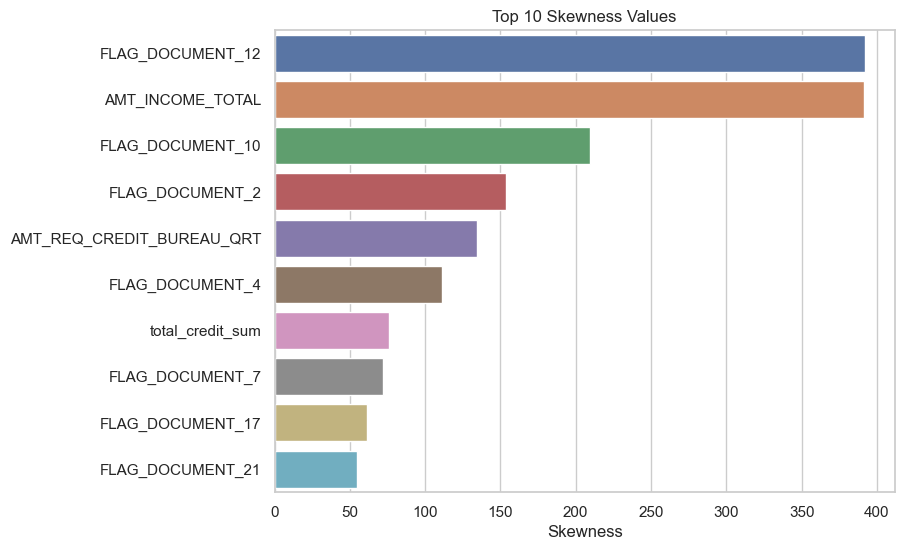

In [9]:
# Top 10 variables les plus asymétriques (skewness)
num_cols = train_df.select_dtypes(include="number").columns.drop("TARGET")
skew_vals = train_df[num_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
top_skew = skew_vals.head(10)

plt.figure(figsize=(8,6))
sns.barplot(x=top_skew.values, y=top_skew.index)
plt.title("Top 10 Skewness Values")
plt.xlabel("Skewness")
plt.show()


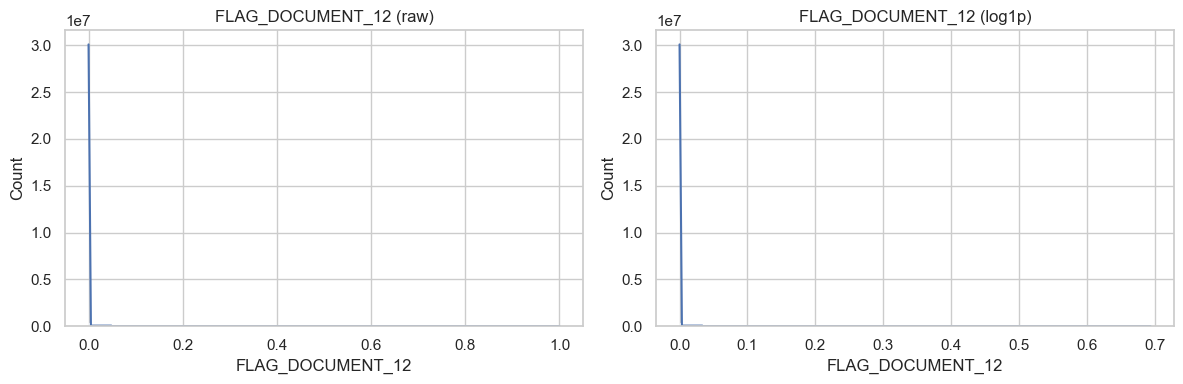

In [10]:
# Exemple de transformation log pour la variable la plus skewed
col = top_skew.index[0]
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(train_df[col], ax=axes[0], kde=True).set_title(f"{col} (raw)")
sns.histplot(np.log1p(train_df[col].clip(lower=0)), ax=axes[1], kde=True).set_title(f"{col} (log1p)")
plt.tight_layout()
plt.show()


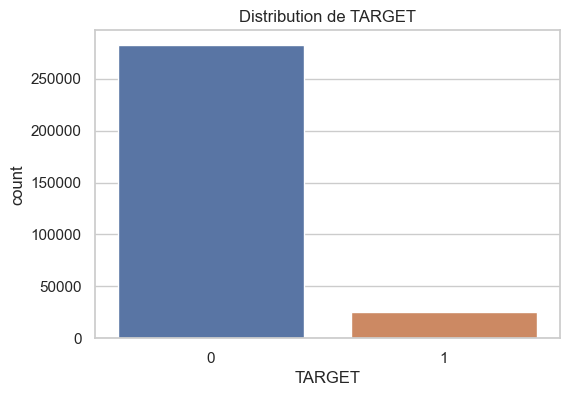

Ratio TARGET:
0    0.919271
1    0.080729
Name: TARGET, dtype: float64


In [11]:
#  Distribution de la cible TARGET
plt.figure(figsize=(6,4))
sns.countplot(x="TARGET", data=train_df)
plt.title("Distribution de TARGET")
plt.show()

print("Ratio TARGET:")
print(train_df["TARGET"].value_counts(normalize=True))


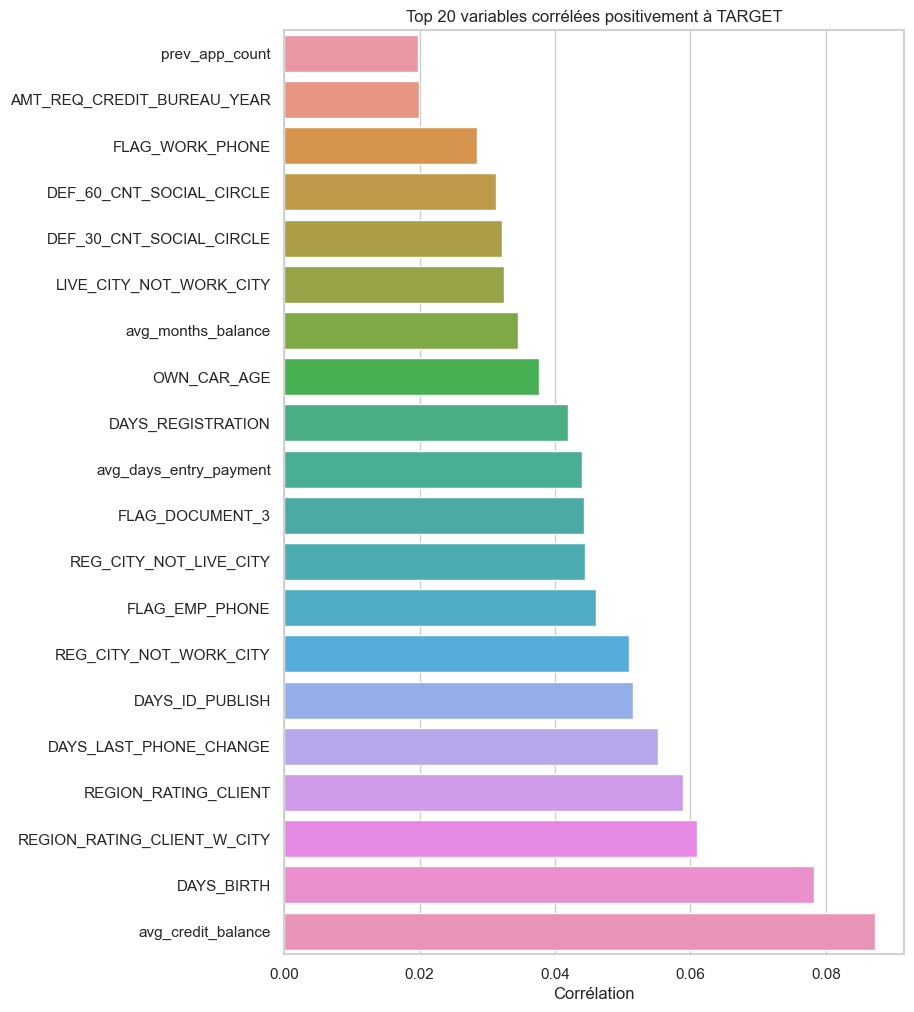

In [13]:
# Corrélation des features avec TARGET (version corrigée)
corrs = train_df.corr()["TARGET"].drop("TARGET").sort_values()

plt.figure(figsize=(8,12))
sns.barplot(x=corrs.tail(20), y=corrs.tail(20).index)
plt.title("Top 20 variables corrélées positivement à TARGET")
plt.xlabel("Corrélation")
plt.show()


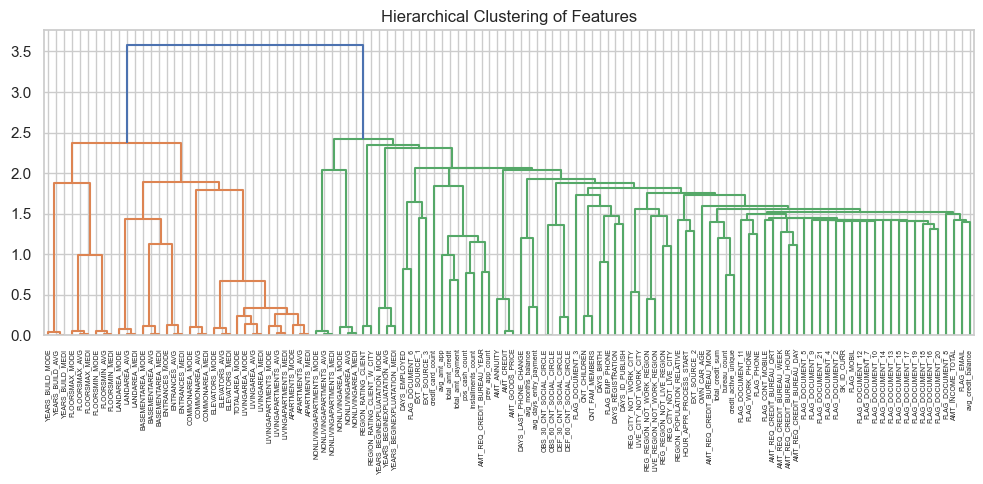

In [14]:
# Clustering hiérarchique des features
corr_matrix = train_df[num_cols].corr().fillna(0)
linkage = sch.linkage(corr_matrix, method='average')

plt.figure(figsize=(10,5))
sch.dendrogram(linkage, labels=corr_matrix.columns, leaf_rotation=90)
plt.title("Hierarchical Clustering of Features")
plt.tight_layout()
plt.show()


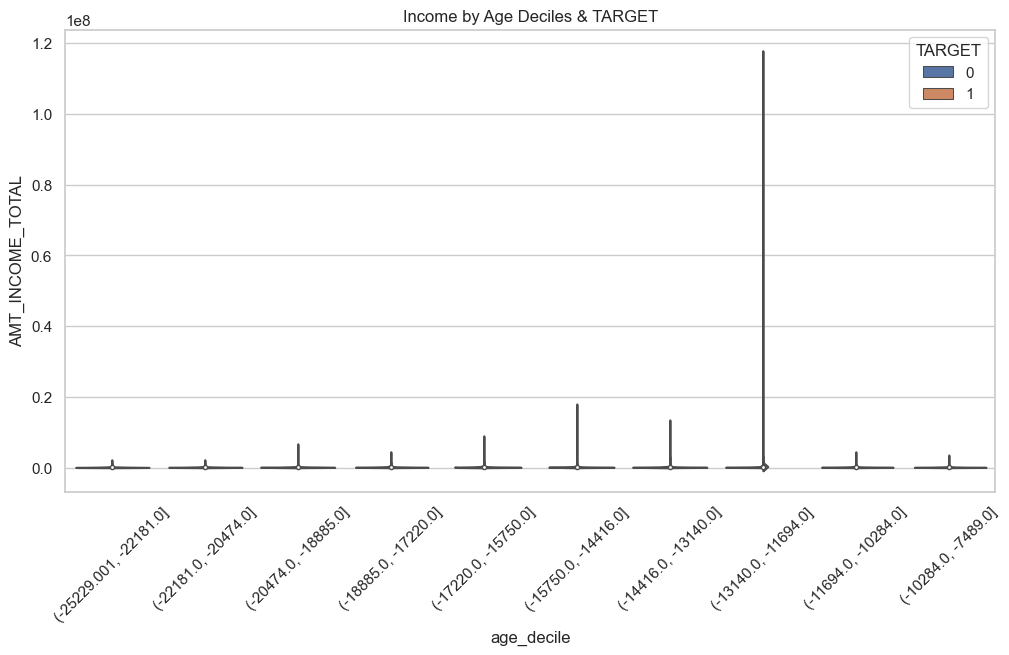

In [15]:
# Violin plot : revenus par tranche d'âge et TARGET
# Créer déciles d'âge
train_df["age_decile"] = pd.qcut(train_df["DAYS_BIRTH"], 10)

plt.figure(figsize=(12,6))
sns.violinplot(x="age_decile", y="AMT_INCOME_TOTAL", hue="TARGET",
               data=train_df, split=True, scale="area")
plt.xticks(rotation=45)
plt.title("Income by Age Deciles & TARGET")
plt.show()


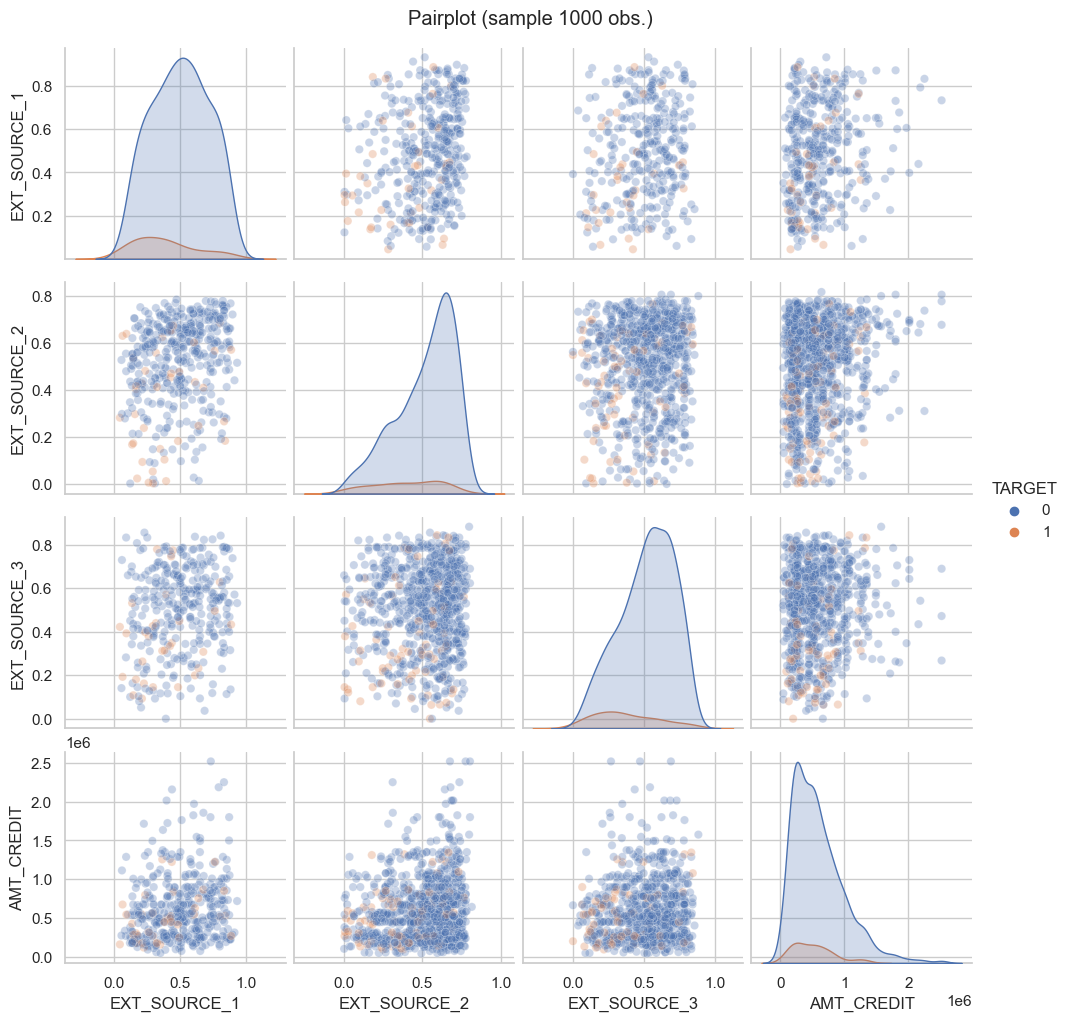

In [16]:
# Pairplot sur un sous-ensemble de features
subset = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "AMT_CREDIT", "TARGET"]
sns.pairplot(train_df[subset].sample(1000), hue="TARGET", plot_kws={"alpha":0.3})
plt.suptitle("Pairplot (sample 1000 obs.)", y=1.02)
plt.show()


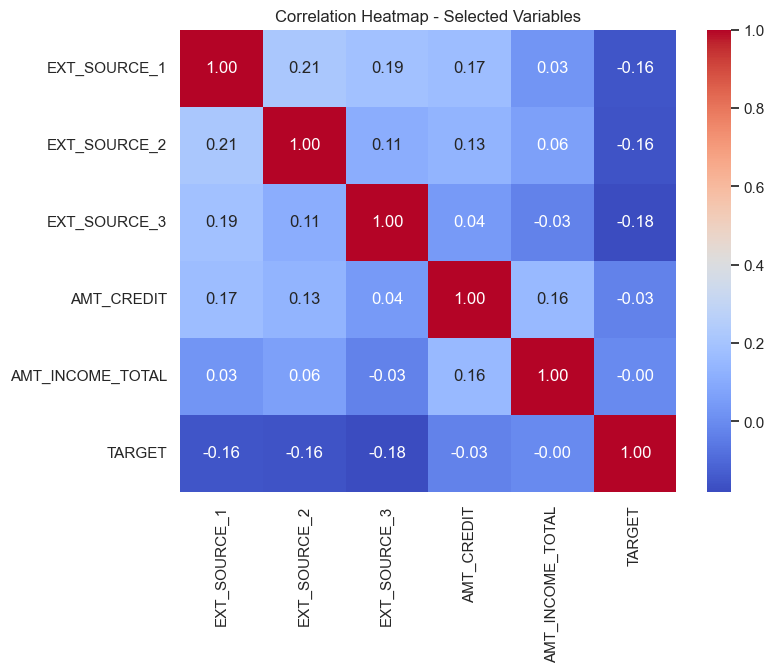

In [17]:
# Heatmap de corrélation sur variables clés
key_vars = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "AMT_CREDIT", "AMT_INCOME_TOTAL", "TARGET"]
plt.figure(figsize=(8,6))
sns.heatmap(train_df[key_vars].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap - Selected Variables")
plt.show()


In [20]:
import pandas as pd

# Patch temporaire pour accepter copy dans infer_objects
if 'copy' not in pd.DataFrame.infer_objects.__code__.co_varnames:
    # Sauvegarde de la méthode originale
    _orig_infer_objects = pd.DataFrame.infer_objects

    def _patched_infer_objects(self, copy=True):
        # Ignore l’argument copy et appelle la méthode d’origine sans param
        return _orig_infer_objects(self)

    pd.DataFrame.infer_objects = _patched_infer_objects


In [4]:
from ydata_profiling import ProfileReport

profile = ProfileReport(train_df, title="Advanced EDA Report", explorative=True)
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|█████████████████████████████████████████| 135/135 [00:43<00:00,  3.10it/s]
